In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

!pip install tensorflow-datasets
!pip install datasets
import tensorflow_datasets as tfds
%matplotlib inline

In [ ]:
ds_train, ds_test = tfds.load('huggingface:svhn/cropped_digits', split=['train','test'])

/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/core/dataset_builders/huggingface_dataset_builder.py:156: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  hf_names = hf_datasets.list_datasets()


Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn/cropped_digits/1.0.0.incomplete19N2K7/svhn-train.tfrecord*...:   0%| …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn/cropped_digits/1.0.0.incomplete19N2K7/svhn-test.tfrecord*...:   0%|  …

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn/cropped_digits/1.0.0.incomplete19N2K7/svhn-extra.tfrecord*...:   0%| …

Dataset svhn downloaded and prepared to /root/tensorflow_datasets/svhn/cropped_digits/1.0.0. Subsequent calls will reuse this data.


In [ ]:
x_train_list = []
x_test_list = []
y_train_list = []
y_test_list = []

for example in ds_train:
  x_train_list.append(example['image'])
  y_train_list.append(example['label'])

for example in ds_test:
  x_test_list.append(example['image'])
  y_test_list.append(example['label'])

In [ ]:
x_train = np.array(x_train_list)
x_test = np.array(x_test_list)

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

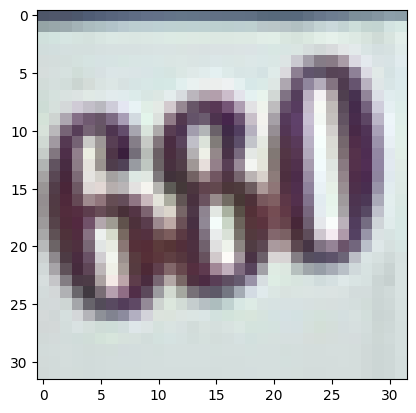

8


In [ ]:
data = np.array(x_train[1].reshape(32,32,3))
plt.imshow(data, vmin=0, vmax=255)
plt.show()
print(y_train[1])

In [ ]:
# Funzione per convertire le immagini in bianco e nero
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

(32, 32)


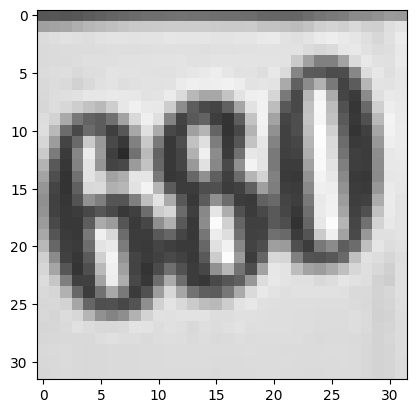

In [ ]:
gray = rgb2gray(np.array(x_train[1].reshape(32,32,3)))
print(gray.shape)
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

In [ ]:
#Trasformazione di tutte le immagini in bianco e nero
x_train_gray_list = []
x_test_gray_list = []

for image in x_train:
  gray_image = rgb2gray(np.array(image.reshape(32,32,3)))
  x_train_gray_list.append(gray_image)

for image in x_test:
  gray_image = rgb2gray(np.array(image.reshape(32,32,3)))
  x_test_gray_list.append(gray_image)

x_train_gray = np.array(x_train_gray_list)
x_test_gray = np.array(x_test_gray_list)

print(x_train_gray.shape)
print(x_test_gray.shape)

(73257, 32, 32)
(26032, 32, 32)


In [ ]:
generator = np.random.default_rng(seed=5)
idx = generator.integers(low=0, high=x_train.shape[0], size=10000)

# Normalizzazione delle immagini in un range tra 0 e 1
x_train_norm = (x_train_gray/255).reshape(x_train.shape[0], -1)[idx,:]
x_test_norm = (x_test_gray/255).reshape(x_test.shape[0], -1)
y_train_cut = y_train[idx]



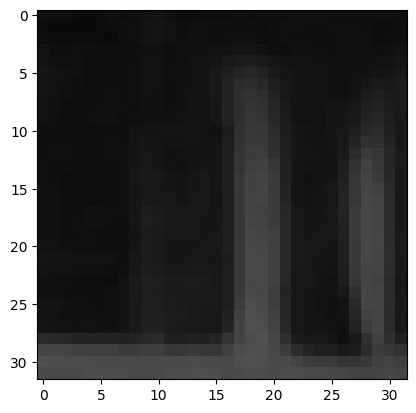

8


In [ ]:
data = np.array(x_train_norm[1].reshape(32,32))
plt.imshow(data, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(y_train[1])

In [ ]:
def train(leaf, tree, bootstrap_resampling):

  # Training on the existing dataset
  rf_clf = RandomForestClassifier(n_estimators = tree, criterion = "entropy",
                                  max_leaf_nodes = leaf, bootstrap = bootstrap_resampling)
  rf_clf.fit(x_train_norm, y_train_cut)


  # Evaluating the model
  pred_train = rf_clf.predict(x_train_norm)
  pred_test = rf_clf.predict(x_test_norm)

  zero_one_loss_train = 1-accuracy_score(y_train_cut, pred_train)
  zero_one_loss_test = 1-accuracy_score(y_test, pred_test)

  pred_train_int = [int(pred) for pred in pred_train]
  pred_test_int = [int(pred) for pred in pred_test]
  y_train_int = [int(y) for y in y_train_cut]
  y_test_int = [int(y) for y in y_test]


  squared_loss_train = mean_squared_error(y_train_int,pred_train_int, squared = True)
  squared_loss_test = mean_squared_error(y_test_int, pred_test_int, squared = True)

  return zero_one_loss_train, zero_one_loss_test, squared_loss_train, squared_loss_test


In [ ]:
def get_losses(bootstrap_resampling):
  results_zero_one_loss_train = []
  results_zero_one_loss_test = []
  results_squared_loss_train = []
  results_squared_loss_test = []

  trees = range(2,21)


  if bootstrap_resampling == True:
    # With bootstrap re-sampling
    leafs = range(100, 2620, 120)
    stop_trees = 2500
  else:
    # Without bootstrap re-sampling
      leafs = range(100, 3775, 175)
      stop_trees = 3600


  for leaf in leafs:
    zero_one_loss_train, zero_one_loss_test, squared_loss_train, squared_loss_test = train(leaf, 1, bootstrap_resampling)
    results_zero_one_loss_train.append(zero_one_loss_train)
    results_zero_one_loss_test.append(zero_one_loss_test)
    results_squared_loss_train.append(squared_loss_train)
    results_squared_loss_test.append(squared_loss_test)

    if(leaf == stop_trees):
      for tree in trees:
        zero_one_loss_train, zero_one_loss_test, squared_loss_train, squared_loss_test = train(leaf,tree, bootstrap_resampling)
        results_zero_one_loss_train.append(zero_one_loss_train)
        results_zero_one_loss_test.append(zero_one_loss_test)
        results_squared_loss_train.append(squared_loss_train)
        results_squared_loss_test.append(squared_loss_test)

  return results_zero_one_loss_train, results_zero_one_loss_test, results_squared_loss_train, results_squared_loss_test



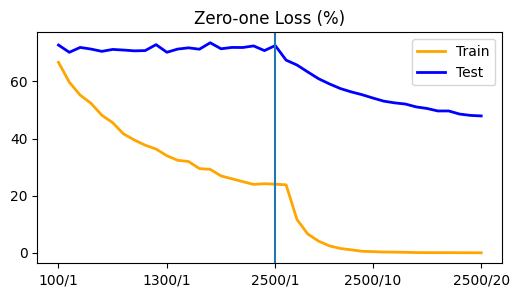

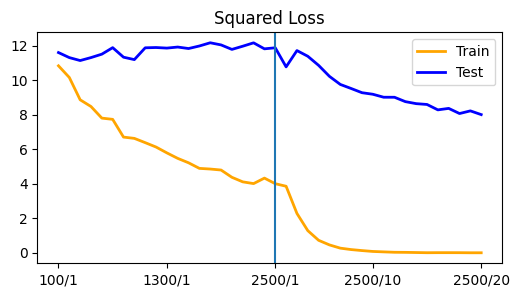

In [ ]:
# Printa i grafici quando c'è il boostrap resampling
results_zero_one_loss_train, results_zero_one_loss_test, results_squared_loss_train, results_squared_loss_test = get_losses(True)
labels = range(0,40)

# Prima immagine
plt.figure(figsize=(6,3))

plt.title("Zero-one Loss (%)")
plt.plot(labels, np.array(results_zero_one_loss_train)*100, linewidth=2.0, color = 'orange', label = "Train")
plt.plot(labels, np.array(results_zero_one_loss_test)*100, linewidth=2.0, color = 'blue', label = "Test")
plt.legend()

plt.xticks([0, 10, 20, 29, 39], ["100/1", "1300/1", "2500/1", "2500/10", "2500/20"])

plt.axvline(x=20)

plt.show()

print()

plt.figure(figsize=(6,3))

plt.title("Squared Loss")
plt.plot(labels, results_squared_loss_train, linewidth=2.0, color = 'orange', label = "Train")
plt.plot(labels, results_squared_loss_test, linewidth=2.0, color = 'blue', label = "Test")
plt.legend()
plt.axvline(x=20)
plt.xticks([0, 10, 20, 29, 39], ["100/1", "1300/1", "2500/1", "2500/10", "2500/20"])


plt.show()


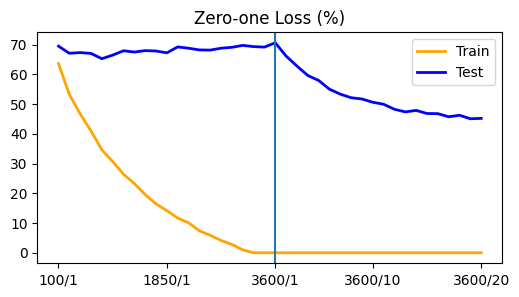

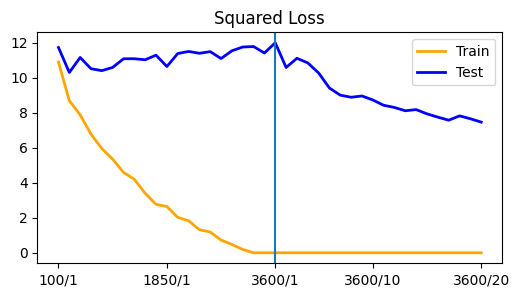

In [ ]:
# Printa i grafici quando non c'è il boostrap resampling
results_zero_one_loss_train, results_zero_one_loss_test, results_squared_loss_train, results_squared_loss_test = get_losses(False)
labels = range(0,40)

# Prima immagine
plt.figure(figsize=(6,3))

plt.title("Zero-one Loss (%)")
plt.plot(labels, np.array(results_zero_one_loss_train)*100, linewidth=2.0, color = 'orange', label = "Train")
plt.plot(labels, np.array(results_zero_one_loss_test)*100, linewidth=2.0, color = 'blue', label = "Test")
plt.legend()

plt.xticks([0, 10, 20, 29, 39], ["100/1", "1850/1", "3600/1", "3600/10", "3600/20"])

plt.axvline(x=20)

plt.show()

plt.figure(figsize=(6,3))

plt.title("Squared Loss")
plt.plot(labels, results_squared_loss_train, linewidth=2.0, color = 'orange', label = "Train")
plt.plot(labels, results_squared_loss_test, linewidth=2.0, color = 'blue', label = "Test")
plt.legend()
plt.axvline(x=20)
plt.xticks([0, 10, 20, 29, 39], ["100/1", "1850/1", "3600/1", "3600/10", "3600/20"])


plt.show()
